In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import imblearn
from sklearn.metrics import roc_auc_score

# EDA

In [5]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
submission = pd.read_csv("sample_submission.csv", index_col=0)

In [6]:
train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0


In [7]:
train.describe()[1:].style.background_gradient()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
mean,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


In [8]:
train.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
test.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [10]:
train['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [11]:
train['gender'].value_counts()

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [12]:
train[train["gender"]=="Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9363,Other,9.0,0,0,No,children,Rural,96.04,18.0,Unknown,0


In [13]:
test[test["gender"]=="Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
19933,Other,56.0,0,0,Yes,Private,Urban,102.53,35.0,Unknown


In [14]:
train['hypertension'].unique()

array([0, 1])

In [15]:
train['hypertension'].value_counts()

0    14543
1      761
Name: hypertension, dtype: int64

In [16]:
train['heart_disease'].unique()

array([0, 1])

In [17]:
train['heart_disease'].value_counts()

0    14947
1      357
Name: heart_disease, dtype: int64

In [18]:
train['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [19]:
train['ever_married'].value_counts()

Yes    10385
No      4919
Name: ever_married, dtype: int64

In [20]:
train['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [21]:
train['work_type'].value_counts()

Private          9752
children         2038
Self-employed    1939
Govt_job         1533
Never_worked       42
Name: work_type, dtype: int64

In [22]:
train['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [23]:
train['Residence_type'].value_counts()

Rural    7664
Urban    7640
Name: Residence_type, dtype: int64

In [24]:
train['smoking_status'].unique()

array(['never smoked', 'formerly smoked', 'Unknown', 'smokes'],
      dtype=object)

In [25]:
train['smoking_status'].value_counts()

never smoked       6281
Unknown            4543
formerly smoked    2337
smokes             2143
Name: smoking_status, dtype: int64

In [26]:
# map binary features (ever_married, Residence_type) to 0 and 1
train["married_ever"] = train["ever_married"].map({'No': 0, 'Yes': 1})
train["urban"] = train["Residence_type"].map({'Rural': 0, 'Urban': 1})
train = train.drop(['ever_married', "Residence_type"], axis = 1)

test["married_ever"] = test["ever_married"].map({'No': 0, 'Yes': 1})
test["urban"] = test["Residence_type"].map({'Rural': 0, 'Urban': 1})
test = test.drop(['ever_married', "Residence_type"], axis = 1)

In [27]:
test[test["age"]<2]["work_type"].value_counts()

children    210
Private       2
Name: work_type, dtype: int64

In [28]:
# one-hot-encoding (gender, work_type, smoking_status)
train = pd.get_dummies(train)   
test = pd.get_dummies(test)

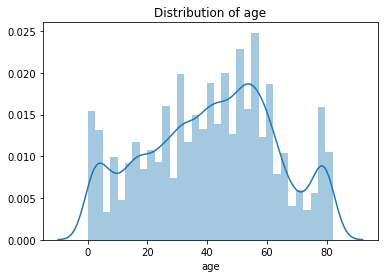

In [29]:
# plot distributions
sns.distplot(train['age']).set(title="Distribution of age");

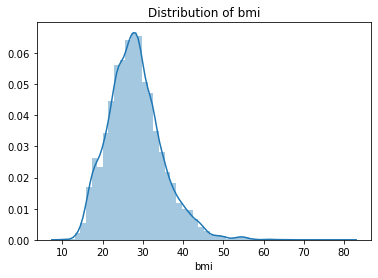

In [30]:
sns.distplot(train['bmi']).set(title="Distribution of bmi");

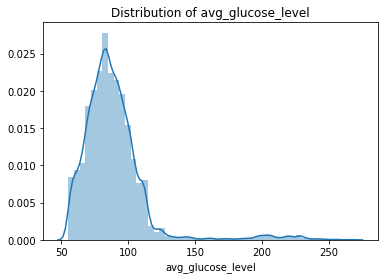

In [31]:
sns.distplot(train['avg_glucose_level']).set(title="Distribution of avg_glucose_level");

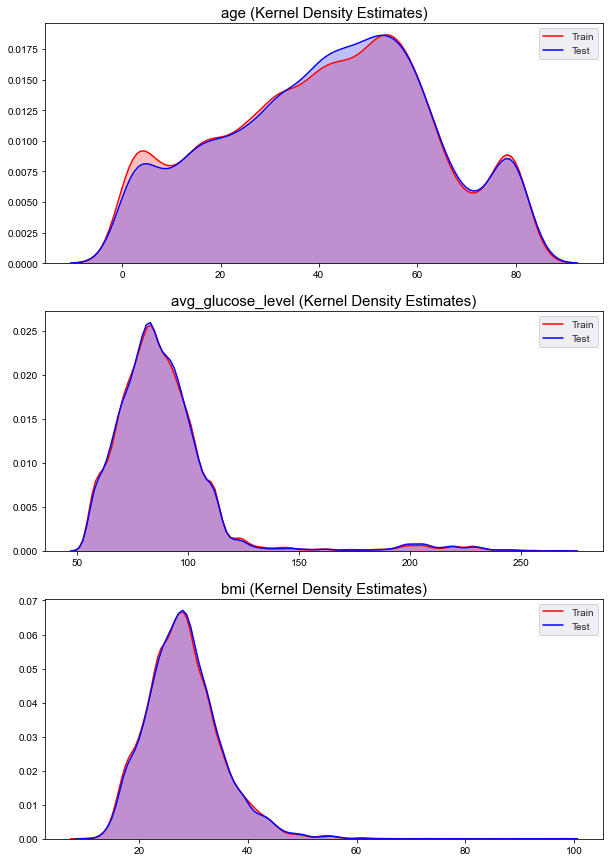

In [32]:
cont_features = ["age", "avg_glucose_level", "bmi"]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

sns.set_style('darkgrid')

axs = axs.flatten()

axis_counter = 0

for _, feature in enumerate(cont_features):
    _ = sns.kdeplot(train[feature], shade=True, color="r", ax=axs[axis_counter], label="Train")
    _ = sns.kdeplot(test[feature], shade=True, color="b", ax=axs[axis_counter], label="Test")
    _ = axs[axis_counter].set_title("{} (Kernel Density Estimates)".format(feature), fontsize=15)
    _ = axs[axis_counter].set_ylabel("")
    _ = axs[axis_counter].set_xlabel("")
    handles, labels = axs[axis_counter].get_legend_handles_labels()
    axs[axis_counter].legend(handles=handles, labels=labels, title="")   
    axis_counter += 1

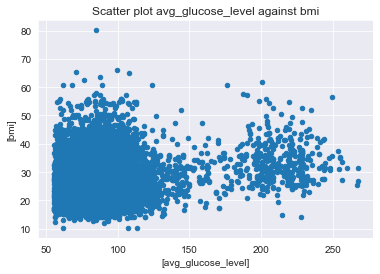

In [33]:
train.plot.scatter(x=["avg_glucose_level"], y=["bmi"], title='Scatter plot avg_glucose_level against bmi');

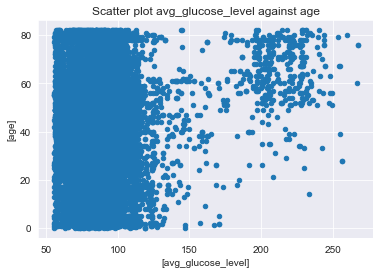

In [34]:
train.plot.scatter(x=["avg_glucose_level"], y=["age"], title='Scatter plot avg_glucose_level against age');

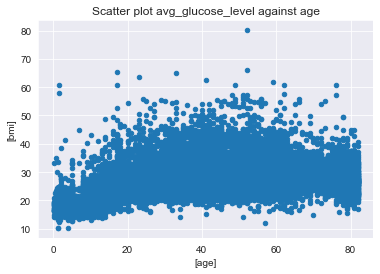

In [35]:
train.plot.scatter(x=["age"], y=["bmi"], title='Scatter plot avg_glucose_level against age');

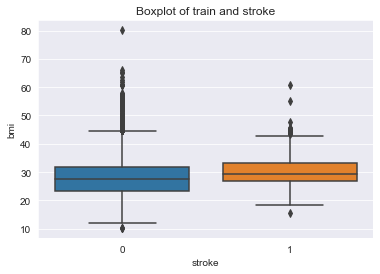

In [37]:
sns.boxplot(x=train['stroke'], y=train['bmi']).set(title="Boxplot of stroke and bmi");

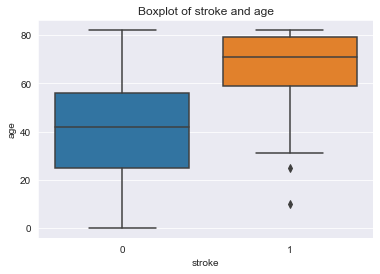

In [38]:
sns.boxplot(x=train['stroke'], y=train['age']).set(title="Boxplot of stroke and age");

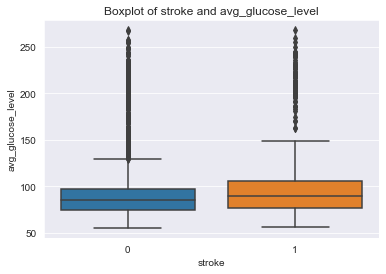

In [39]:
sns.boxplot(x=train['stroke'], y=train['avg_glucose_level']).set(title="Boxplot of stroke and avg_glucose_level");

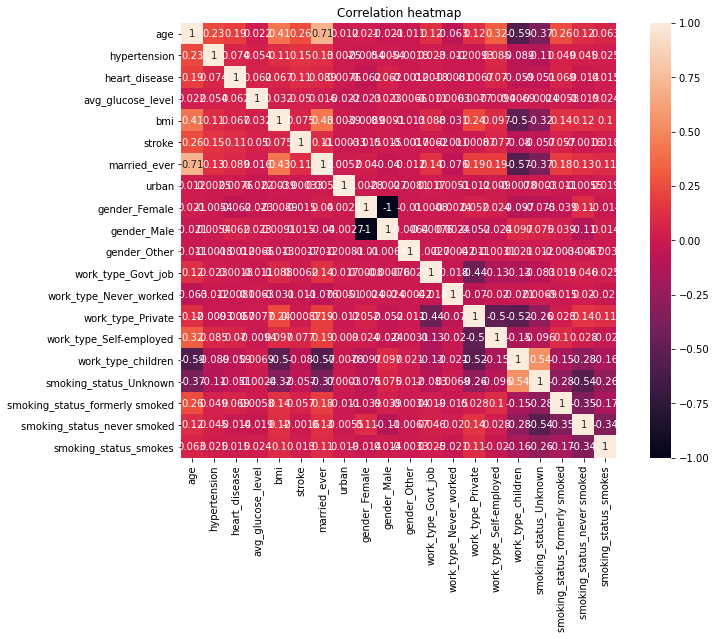

In [31]:
fig, ax = plt.subplots(figsize=(12,8)) 
corrmat = train.corr(method="spearman")
sns.heatmap(corrmat, square=True, annot=True, vmin = -1, vmax = 1, ax=ax).set(title='Correlation heatmap');

## Modeling

In [32]:
model1 = lgb.LGBMRegressor()
model1.fit(train.drop("stroke", axis=1), train["stroke"])

LGBMRegressor()

In [33]:
ypred1 = model1.predict(test)

In [34]:
ypred1

array([3.11637069e-02, 1.95800763e-01, 1.81028938e-03, ...,
       1.81028938e-03, 2.42097810e-03, 6.72490244e-06])

In [35]:
submission["stroke"] = ypred1

In [36]:
submission

,stroke
id,
15304,0.031164
15305,0.195801
15306,0.001810
15307,0.015300
15308,-0.000170
...,...
25503,0.001871
25504,0.012154
25505,0.001810


In [37]:
submission.to_csv("submission1.csv")

# V2

In [38]:
model2 = lgb.LGBMClassifier()
model2.fit(train.drop("stroke", axis=1), train["stroke"])

LGBMClassifier()

In [39]:
ypred2 = model2.predict(test)

In [40]:
ypred2

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
submission["stroke"] = ypred2

In [42]:
submission["stroke"].value_counts()

0    10119
1       85
Name: stroke, dtype: int64

In [43]:
submission.to_csv("submission2.csv")

# V3

In [44]:
model3 = lgb.LGBMClassifier()
model3.fit(train.drop("stroke", axis=1), train["stroke"])

LGBMClassifier()

In [45]:
ypred3 = model3.predict_proba(test)

In [46]:
ypred3

array([[9.71366428e-01, 2.86335718e-02],
       [8.94054036e-01, 1.05945964e-01],
       [9.99909021e-01, 9.09790115e-05],
       ...,
       [9.99909014e-01, 9.09855074e-05],
       [9.99484372e-01, 5.15628121e-04],
       [9.99919664e-01, 8.03362201e-05]])

In [47]:
submission["stroke"] = 1-ypred3

In [48]:
submission["stroke"].mean()

0.03832196835302565

In [49]:
submission

,stroke
id,
15304,0.028634
15305,0.105946
15306,0.000091
15307,0.293286
15308,0.001346
...,...
25503,0.000130
25504,0.006768
25505,0.000091


In [50]:
submission.to_csv("submission3.csv")

# V4

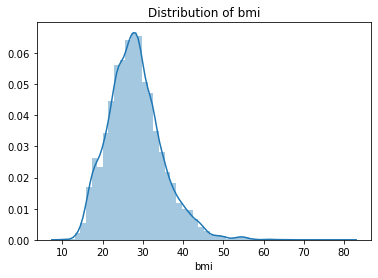

In [51]:
#BMI [10-55]
#average glucose level
sns.distplot(train['bmi']).set(title="Distribution of bmi");

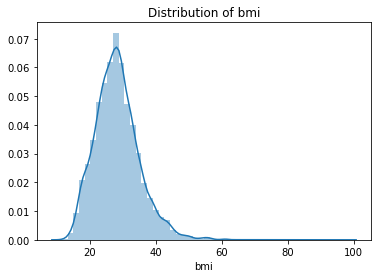

In [52]:
sns.distplot(test['bmi']).set(title="Distribution of bmi");

In [53]:
#binning BMI
train["underweight"] = (train["bmi"]<20).astype(int)
test["underweight"] = (test["bmi"]<20).astype(int)

train["healthy"] = (train["bmi"]>19).astype(int)*(train["bmi"]<25).astype(int)
test["healthy"] = (test["bmi"]>19).astype(int)*(test["bmi"]<25).astype(int)

train["overweight"] = (train["bmi"]>24).astype(int)*(train["bmi"]<30).astype(int)
test["overweight"] = (test["bmi"]>24).astype(int)*(test["bmi"]<30).astype(int)

train["obese"] = (train["bmi"]>29).astype(int)*(train["bmi"]<41).astype(int)
test["obese"] = (test["bmi"]>29).astype(int)*(test["bmi"]<41).astype(int)

train["extremely_obese"] = (train["bmi"]>40).astype(int)*(train["bmi"]<51).astype(int)
test["extremely_obese"] = (test["bmi"]>40).astype(int)*(test["bmi"]<51).astype(int)

train["irregular_bmi"] = (train["bmi"]>50).astype(int)
test["irregular_bmi"] = (test["bmi"]>50).astype(int)

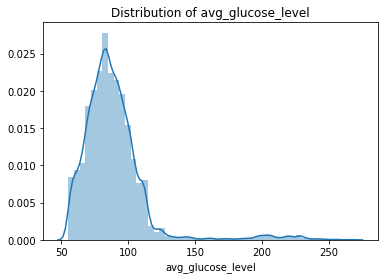

In [54]:
sns.distplot(train['avg_glucose_level']).set(title="Distribution of avg_glucose_level");

In [55]:
train["diabetic"] = (train["avg_glucose_level"]>200).astype(int)
test["diabetic"] = (test["avg_glucose_level"]>200).astype(int)

train["pre_diabetic"] = (train["avg_glucose_level"]>120).astype(int)*(train["avg_glucose_level"]<201).astype(int)
test["pre_diabetic"] = (test["avg_glucose_level"]>120).astype(int)*(test["avg_glucose_level"]>201).astype(int)

train["not_diabetic"] = (train["avg_glucose_level"]<121).astype(int)
test["not_diabetic"] = (test["avg_glucose_level"]>121).astype(int)

In [56]:
train["gluc_per_bmi"] = train["avg_glucose_level"]/train["bmi"]
test["gluc_per_bmi"] = test["avg_glucose_level"]/test["bmi"]

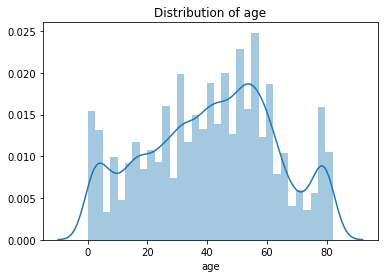

In [57]:
sns.distplot(train['age']).set(title="Distribution of age");

In [58]:
train[train["age"]<16]

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,married_ever,urban,gender_Female,gender_Male,...,underweight,healthy,overweight,obese,extremely_obese,irregular_bmi,diabetic,pre_diabetic,not_diabetic,gluc_per_bmi
id,,,,,,,,,,,,,,,,,,,,,
12,4.00,0,0,84.10,14.1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,5.964539
21,1.72,0,0,94.12,20.8,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,4.525000
28,12.00,0,0,84.11,23.5,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,3.579149
30,4.00,0,0,60.73,18.0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,3.373889
38,8.00,0,0,85.79,18.3,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,4.687978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15287,5.00,0,0,94.33,18.2,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,5.182967
15292,0.32,0,0,89.04,17.8,0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,5.002247
15295,12.00,0,0,69.78,14.3,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,4.879720


In [59]:
with pd.option_context('display.max_rows', None):
    print(train["age"].value_counts())

57.00    353
78.00    337
53.00    311
31.00    310
45.00    309
52.00    308
55.00    303
37.00    295
50.00    294
56.00    286
54.00    285
49.00    282
32.00    275
43.00    273
5.00     270
79.00    269
51.00    265
34.00    264
39.00    263
44.00    256
61.00    254
59.00    248
47.00    247
42.00    246
38.00    243
40.00    236
60.00    230
41.00    230
26.00    227
62.00    224
58.00    218
27.00    210
8.00     206
46.00    203
48.00    200
63.00    195
18.00    194
20.00    191
23.00    188
17.00    188
33.00    182
80.00    180
14.00    176
13.00    173
2.00     172
25.00    170
30.00    170
24.00    167
35.00    165
16.00    165
65.00    161
28.00    154
3.00     146
66.00    144
19.00    130
81.00    127
29.00    125
21.00    119
12.00    109
36.00    108
64.00    104
71.00     98
22.00     98
69.00     96
82.00     94
15.00     91
67.00     91
10.00     85
4.00      84
9.00      84
75.00     84
7.00      78
73.00     74
11.00     73
76.00     71
72.00     68
74.00     62

In [60]:
# clean "age" feature
with pd.option_context('display.max_rows', None):
    print(test[test["age"]<2]["age"].value_counts())

1.80    19
1.88    18
1.32    17
1.24    16
1.48    15
1.08    13
1.72    13
1.64    13
0.32    11
1.56    11
0.72    10
1.00     9
1.16     7
0.24     7
0.80     6
0.88     6
0.56     5
0.64     4
0.40     3
1.40     2
0.48     2
0.08     2
0.33     1
1.25     1
1.90     1
Name: age, dtype: int64


In [61]:
with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    print(train[train["age"]<2][["age", "stroke"]])

        age  stroke
id                 
21     1.72       0
104    0.32       0
176    1.32       0
205    1.32       0
259    1.80       0
260    1.88       0
272    0.88       0
311    1.48       0
399    1.30       0
422    0.16       0
425    1.88       0
467    0.80       0
504    1.32       0
518    1.48       0
562    1.32       0
563    1.72       0
617    1.64       0
746    1.40       0
767    1.48       0
769    1.64       0
921    1.48       0
942    0.64       0
967    0.40       0
1049   1.32       0
1073   1.80       0
1095   1.48       0
1110   1.80       0
1223   1.72       0
1258   1.24       0
1265   1.72       0
1305   0.32       0
1311   1.08       0
1538   1.32       0
1569   0.72       0
1578   1.88       0
1707   1.32       0
1720   0.56       0
1724   0.80       0
1725   1.72       0
1771   1.88       0
1789   0.64       0
1797   1.64       0
1821   1.24       0
1857   1.80       0
1862   1.24       0
1869   1.00       0
1917   0.80       0
1952   0.72       0


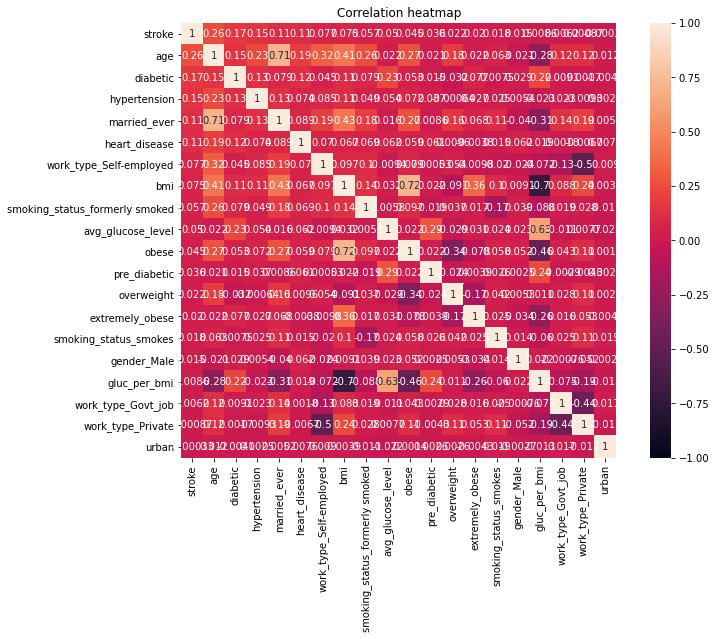

In [62]:
fig,ax = plt.subplots(figsize=(12,8)) 
corrmat = train.corr(method="spearman")
cols = corrmat.nlargest(20, 'stroke').index
sns.heatmap(corrmat.loc[cols, cols], square=True, annot=True, vmin = -1, vmax = 1, ax=ax).set(title='Correlation heatmap');

In [63]:
model4 = lgb.LGBMClassifier()
model4.fit(train.drop("stroke", axis=1), train["stroke"])

LGBMClassifier()

In [64]:
ypred4 = model4.predict_proba(test)

In [65]:
ypred4

array([[9.61985274e-01, 3.80147255e-02],
       [9.04852769e-01, 9.51472311e-02],
       [9.99898843e-01, 1.01156736e-04],
       ...,
       [9.99932796e-01, 6.72037874e-05],
       [9.98958819e-01, 1.04118072e-03],
       [9.99930225e-01, 6.97754372e-05]])

In [66]:
submission["stroke"] = 1-ypred4

In [67]:
submission["stroke"].mean()

0.038471037227799265

In [68]:
submission

,stroke
id,
15304,0.038015
15305,0.095147
15306,0.000101
15307,0.024262
15308,0.001184
...,...
25503,0.000115
25504,0.003810
25505,0.000067


In [69]:
submission.to_csv("submission4.csv")

# V5

In [3]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
submission = pd.read_csv("sample_submission.csv", index_col=0)

# map binary features (ever_married, Residence_type) to 0 and 1
train["married_ever"] = train["ever_married"].map({'No': 0, 'Yes': 1})
train["urban"] = train["Residence_type"].map({'Rural': 0, 'Urban': 1})
train = train.drop(['ever_married', "Residence_type"], axis = 1)

test["married_ever"] = test["ever_married"].map({'No': 0, 'Yes': 1})
test["urban"] = test["Residence_type"].map({'Rural': 0, 'Urban': 1})
test = test.drop(['ever_married', "Residence_type"], axis = 1)

# one-hot-encoding (gender, work_type, smoking_status)
train = pd.get_dummies(train)   
test = pd.get_dummies(test)

In [4]:
train["stroke"].value_counts()

0    14672
1      632
Name: stroke, dtype: int64

In [5]:
model5 = lgb.LGBMRegressor()
model5.fit(train.drop("stroke", axis=1), train["stroke"])

LGBMRegressor()

In [6]:
ypred5 = model5.predict(test)

In [7]:
ypred5

array([3.11637069e-02, 1.95800763e-01, 1.81028938e-03, ...,
       1.81028938e-03, 2.42097810e-03, 6.72490244e-06])

In [8]:
submission["stroke"] = ypred5

In [9]:
submission["stroke"].mean()

0.0410343184302722

In [10]:
submission

,stroke
id,
15304,0.031164
15305,0.195801
15306,0.001810
15307,0.015300
15308,-0.000170
...,...
25503,0.001871
25504,0.012154
25505,0.001810


In [14]:
submission[submission["stroke"]<0] = 0

In [15]:
submission["stroke"].min()

0.0

In [19]:
submission["stroke"].mean()

0.04157068546141449

In [20]:
submission.to_csv("submission5.csv")

# V6

In [64]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
submission = pd.read_csv("sample_submission.csv", index_col=0)

# map binary features (ever_married, Residence_type) to 0 and 1
train["married_ever"] = train["ever_married"].map({'No': 0, 'Yes': 1})
train["urban"] = train["Residence_type"].map({'Rural': 0, 'Urban': 1})
train = train.drop(['ever_married', "Residence_type"], axis = 1)

test["married_ever"] = test["ever_married"].map({'No': 0, 'Yes': 1})
test["urban"] = test["Residence_type"].map({'Rural': 0, 'Urban': 1})
test = test.drop(['ever_married', "Residence_type"], axis = 1)



In [65]:
# map smoking_status to an ordinal feature (never smoked, unknown, smokes, formerly smoked)
train["smoking_status_"] = train["smoking_status"].map({'never smoked': 1, 'Unknown': 2, 'smokes': 3, 'formerly smoked': 4})
train = train.drop(["smoking_status"], axis = 1)

test["smoking_status_"] = test["smoking_status"].map({'never smoked': 1, 'Unknown': 2, 'smokes': 3, 'formerly smoked': 4})
test = test.drop(["smoking_status"], axis = 1)


In [66]:
# one-hot-encoding (gender, work_type, smoking_status)
train = pd.get_dummies(train)   
test = pd.get_dummies(test)

In [68]:
model6 = lgb.LGBMClassifier()
model6.fit(train.drop("stroke", axis=1), train["stroke"], eval_metric=roc_auc_score)

LGBMClassifier()

In [69]:
ypred6 = model6.predict_proba(test)

In [70]:
ypred6

array([[9.57835242e-01, 4.21647580e-02],
       [8.42120102e-01, 1.57879898e-01],
       [9.99946236e-01, 5.37640630e-05],
       ...,
       [9.99945880e-01, 5.41204298e-05],
       [9.99099711e-01, 9.00289488e-04],
       [9.99929693e-01, 7.03068352e-05]])

In [71]:
submission["stroke"] = 1-ypred6

In [72]:
submission["stroke"].mean()

0.038268436922378815

In [73]:
submission

,stroke
id,
15304,0.042165
15305,0.157880
15306,0.000054
15307,0.055087
15308,0.000783
...,...
25503,0.000141
25504,0.003709
25505,0.000054


In [74]:
submission.to_csv("submission6.csv")

# V7

In [104]:
og = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=0)
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
submission = pd.read_csv("sample_submission.csv", index_col=0)

In [105]:
og['bmi'].fillna(og['bmi'].mean(), inplace=True)

In [106]:
og.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [107]:
og['original'] = 1
train['original'] = 0
test['original'] = 0

In [108]:
train = pd.concat([train, og])

In [109]:
len(train)

20414

In [110]:
train["stroke"].value_counts()

0    19533
1      881
Name: stroke, dtype: int64

In [111]:
train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,original
id,,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.100000,never smoked,0,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.900000,formerly smoked,0,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.300000,Unknown,0,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.800000,never smoked,0,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.800000,never smoked,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0,1
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0,1
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0,1


In [112]:
# map binary features (ever_married, Residence_type) to 0 and 1
train["married_ever"] = train["ever_married"].map({'No': 0, 'Yes': 1})
train["urban"] = train["Residence_type"].map({'Rural': 0, 'Urban': 1})
train = train.drop(['ever_married', "Residence_type"], axis = 1)

test["married_ever"] = test["ever_married"].map({'No': 0, 'Yes': 1})
test["urban"] = test["Residence_type"].map({'Rural': 0, 'Urban': 1})
test = test.drop(['ever_married', "Residence_type"], axis = 1)

# one-hot-encoding (gender, work_type, smoking_status)
train = pd.get_dummies(train)   
test = pd.get_dummies(test)

In [113]:
model7 = lgb.LGBMClassifier()
model7.fit(train.drop("stroke", axis=1), train["stroke"], eval_metric=roc_auc_score)

LGBMClassifier()

In [114]:
ypred7 = model7.predict_proba(test)

In [116]:
ypred7

array([[9.60416237e-01, 3.95837628e-02],
       [8.44765778e-01, 1.55234222e-01],
       [9.99911294e-01, 8.87062240e-05],
       ...,
       [9.99973858e-01, 2.61418797e-05],
       [9.98377810e-01, 1.62218993e-03],
       [9.99985095e-01, 1.49049024e-05]])

In [117]:
submission["stroke"] = 1-ypred7

In [118]:
submission["stroke"].mean()

0.038918275967604464

In [119]:
submission

,stroke
id,
15304,0.039584
15305,0.155234
15306,0.000089
15307,0.128657
15308,0.001181
...,...
25503,0.000047
25504,0.008981
25505,0.000026


In [120]:
submission.to_csv("submission7.csv")